In [1]:
%matplotlib inline

In [2]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

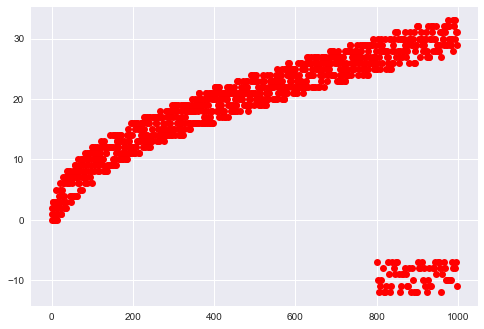

In [3]:
noiseSize = 3
size = 1000

sample = np.arange(size*2).reshape( (2, size) )
sample[1] = np.sqrt( sample[0] )
# sample[1][0] = 0

# add outliers!
for i in range(size - int(size/5), size, 3):
    sample[1][i] = -10
    
sample[1] = sample[1] + (np.random.rand(1,size) - .5) * noiseSize*2
sample = sample.T

plt.plot(sample[:,0], sample[:,1], 'ro')

In [4]:
data = sample
n = 2
m = data.shape[0]
scaleInfo = []

x = data[:, :n-1]
x = np.concatenate((np.ones((1,m)), x.T)).T

for i in range(0, n):
    scaleInfo.append( [ x[:,i].min(), x[:,i].mean(), x[:,i].max()] )
    
for i in range(1, n):
    for j in range(0, m):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / r
        else:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / 1

y = np.array( data[:,-1] )
y = y.T

# print(x)

theta: [ 17.61101824  12.53204748]


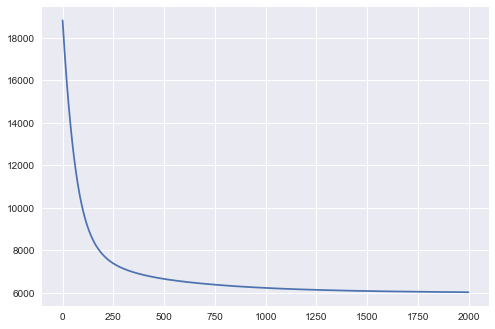

In [5]:
def findRegression(dataX, dataY):
    autoAlphaSelect = True
    iterCount = 2000
    alpha = 10
    theta = np.array(n * [0])

    j = []
    complete = False

    while( not complete ):
        complete = True
        for _ in range(0, iterCount):
            h = np.dot(dataX , theta)
            loss = h - dataY
            gradient = np.dot(loss , dataX)
            theta = theta - alpha / m * gradient
            j += [ abs(np.array(loss)).sum() ]

            for i in range(0,n):
                theta[i] = theta[i] - (alpha / m * dataX[:,1].dot(loss))

            # fix big alpha
            if ( autoAlphaSelect and j[ len(j)-1 ] > j[ len(j)-2 ]):
                complete = False
                alpha = alpha / 10
#                 print('alpha:', alpha)
                theta = np.array(n * [0])
                j.clear()
                break
    return theta, j
                
theta, j = findRegression(x, y)
print('theta:', theta )
plt.plot(j)

In [6]:
def scale(a, scaleInfo):
    result = [1]
    for i in range(1, n):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            result += [( a[i-1] - scaleInfo[i][1] ) / r]
        else:
            result += [( a[i-1] - scaleInfo[i][1] ) / 1]
    return result

(0, 11.344994496823956) (999, 23.877041978233507)


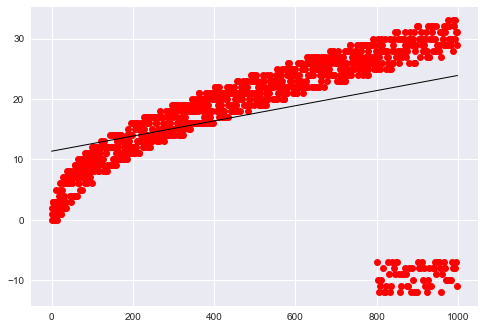

In [7]:
a = (0, np.array(scale([0], scaleInfo)).dot(theta))
b = (m-1, np.array(scale([m-1], scaleInfo)).dot(theta))

print( a, b)
            
plt.plot(sample[:,0], sample[:,1], 'ro')
plt.plot([ a[0], b[0] ], [ a[1], b[1] ], 'k-', lw=1)

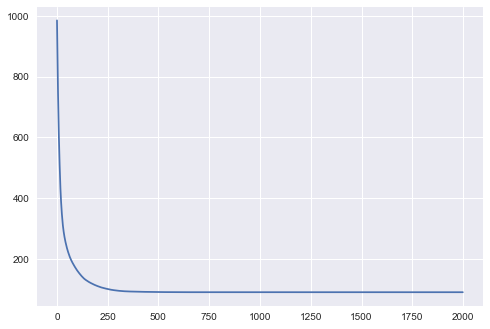

In [8]:
iteration = 100
sampleCount = m * 5 // 100
errorSize = 5

bestFit = 0
bestTheta = None
bestIndex = None
bestJ = None

def findInlinesCount(dataX, dataY, sampleTetha, error):
    dataSize = len(dataY)
    count = 0
    for i in range( dataSize ):
        diff = abs( np.dot(np.array(sampleTetha), np.array(dataX[i])) - dataY[i] )
        if diff < errorSize:
            count += 1
    return count
    
for i in range(iteration):
    sampleDataIndex = random.sample( range(m), sampleCount)
    sampleX = x[ sampleDataIndex ]
    sampleY = y[ sampleDataIndex ]
    sampleTetha, sampleJ = findRegression( sampleX, sampleY )
    
    inlineCound = findInlinesCount(x, y, sampleTetha, errorSize)
    if inlineCound > bestFit:
        bestFit = inlineCound
        bestTheta = sampleTetha
        bestIndex = sampleDataIndex
        bestJ = sampleJ
plt.plot(bestJ)

(0, 7.3267857187639596) (999, 33.09571779319959)
912


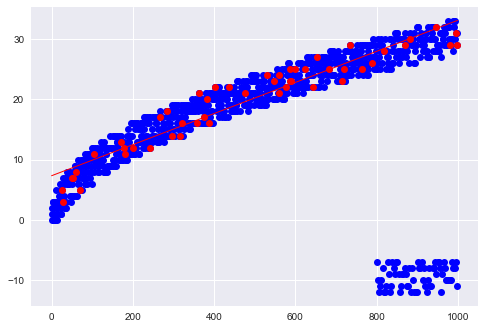

In [9]:
a = (0, np.array(scale([0], scaleInfo)).dot(bestTheta))
b = (m-1, np.array(scale([m-1], scaleInfo)).dot(bestTheta))

print( a, b)
print( bestFit )
            
plt.plot(sample[:,0], sample[:,1], 'bo')
plt.plot([ a[0], b[0] ], [ a[1], b[1] ], 'r-', lw=1)
plt.plot(sample[bestIndex,0], sample[bestIndex,1], 'ro')